# ValueInvestor Project

## Background:


We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.


## Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.


In [1]:
# ingore warnings
import warnings
warnings.filterwarnings('ignore')

# cell output clear tool
from IPython.display import clear_output

# data
import pandas as pd
import numpy as np

# visualisations
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# date
from datetime import datetime
import matplotlib.dates as md

In [2]:
# mount google drive
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Apziva Projects/L5/Data')

Mounted at /content/drive


### Load Data and Data Preprocessing

In [3]:
os.listdir()

['2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv',
 '2020Q1Q2Q3Q4-2021Q1 - Colombia - Cementos Argos SA (CCB).csv',
 '2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv',
 '2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv',
 'model.png']

In [4]:
# load dataset
data = pd.read_csv("2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv")
original_data = data.copy()
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.5,38.81M,-0.02%
2,"Mar 29, 2021",293.3,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.5,287.03,283.85,35.22M,0.30%


In [5]:
# get info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      312 non-null    object
 1   Price     312 non-null    object
 2   Open      312 non-null    object
 3   High      312 non-null    object
 4   Low       312 non-null    object
 5   Vol.      311 non-null    object
 6   Change %  311 non-null    object
dtypes: object(7)
memory usage: 17.2+ KB


In [6]:
# see if there are duplicates rows in the data
sum(data.duplicated())

0

In [7]:
# drop unnecessary columns
data.drop(['Vol.', 'Change %'], axis=1, inplace=True)

# Eliminate last row with summary data
data = data.head(data.shape[0]-1)

# Convert Date to datetime format and organize by date
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y"))
data = data.sort_values('Date')

# Change Price dtype to float
data[['Price', 'Low', 'High', 'Open']] = data[['Price', 'Low', 'High', 'Open']].astype("float32")

# Reset index
data.reset_index(drop=True, inplace=True)

data.head(10)

,Date,Price,Open,High,Low
0,2020-01-03,255.000000,255.990005,258.190002,253.699997
1,2020-01-06,253.899994,254.750000,254.839996,251.399994
2,2020-01-08,259.149994,253.570007,259.149994,253.029999
3,2020-01-09,257.989990,259.399994,261.760010,257.010010
4,2020-01-10,258.190002,257.859985,259.250000,256.880005
5,2020-01-13,262.399994,258.299988,262.399994,257.149994
6,2020-01-14,259.049988,262.500000,263.220001,258.619995
7,2020-01-15,256.309998,258.489990,258.910004,254.210007
8,2020-01-16,257.510010,257.109985,259.510010,256.100006
9,2020-01-17,262.500000,258.200012,262.820007,257.750000


In [8]:
# function that plot the time series
def plot_time_series(timeseries: pd.DataFrame, y: list=[], labels: list=[], colors: list=[]):
    
    sns.set()
    fig, ax = plt.subplots(1, 1, figsize = (20,6))
    
    for i in range(len(y)):
        ax.plot(timeseries['Date'], timeseries[y[i]], label=labels[i], color=colors[i])
    
    ax.xaxis.set_major_locator(md.MonthLocator())
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
    ax.set_ylabel('Stock price')
    ax.set_xlabel('Date')
    ax.tick_params(labelrotation=45)
    ax.legend()
    plt.show()

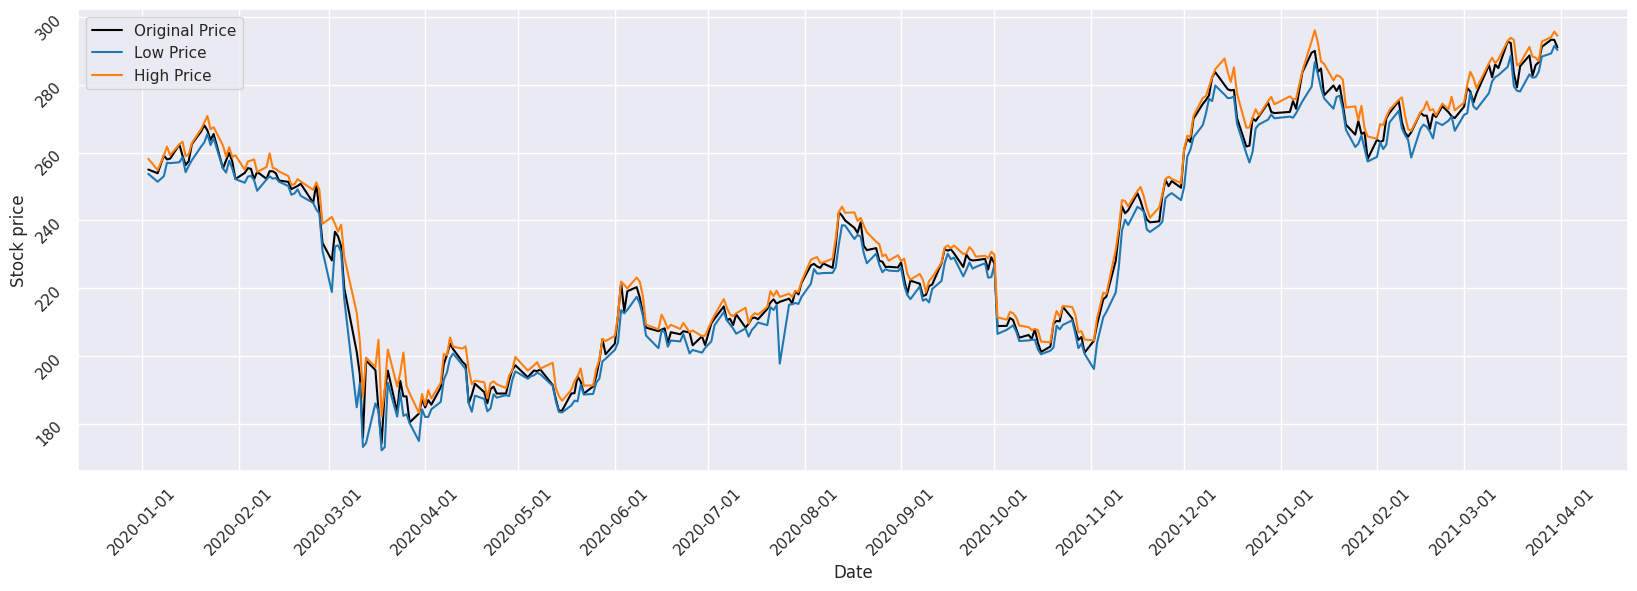

In [9]:
plot_time_series(data, y=['Price', 'Low', 'High'], 
                       labels=['Original Price', 'Low Price', 'High Price'],
                       colors=['black', 'tab:blue', 'tab:orange'])

* We will use LTSM as our model, so we don't need to make our time-series stationary since LTSM can learn from non-linear or non-sationary time-series.

* We will normalize the feature we are gonna use to train our model ,though, to help it.

### Setting target variable and selected features

In [10]:
# separate 2020 and 2021 data
mask = (data['Date'] >= '2021-01-01')
data2021 = data.loc[mask]

mask = (data['Date'] < '2021-01-01')
data2020 = data.loc[mask]

# Set Target Variable
output_var2020 = pd.DataFrame(data2020['Price'])
output_var2021 = pd.DataFrame(data2021['Price'])

# Selecting the Features
features = ['Open', 'High', 'Low']

### Scaling

In [21]:
scaler = MinMaxScaler()

# 2020 data
feature_transform2020 = scaler.fit_transform(data2020[features])
feature_transform2020 = pd.DataFrame(columns=features, data=feature_transform2020, index=data2020.index)
print(feature_transform2020.head())

# 2021 data
feature_transform2021 = scaler.fit_transform(data2021[features])
feature_transform2021 = pd.DataFrame(columns=features, data=feature_transform2021, index=data2021.index)
print(feature_transform2021.head())

       Open      High       Low
0  0.736206  0.720012  0.757688
1  0.724934  0.688270  0.736319
2  0.714208  0.729107  0.751463
3  0.767203  0.753838  0.788442
4  0.753204  0.730055  0.787234
         Open      High       Low
250  0.420827  0.391753  0.388108
251  0.364028  0.363637  0.378442
252  0.457258  0.371135  0.417692
253  0.433448  0.622618  0.519918
254  0.655766  0.902531  0.647921


### Create training set, test set and processing data for LSTM

In [22]:
# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=2)
for train_index, test_index in timesplit.split(feature_transform2020):
        X_train = feature_transform2020[:len(train_index)]
        y_train = output_var2020[:len(train_index)].values.ravel()

for train_index, test_index in timesplit.split(feature_transform2021):
        X_test = feature_transform2021[len(train_index): (len(train_index)+len(test_index))]
        y_test = output_var2021[len(train_index): (len(train_index)+len(test_index))].values.ravel()

We must divide the entire dataset into training and test sets before feeding it into the training model. The Machine Learning LSTM model will be trained on the data in the training set and tested for accuracy and backpropagation on the test set.

The sci-kit-learn library’s TimeSeriesSplit class will be used for this. We set the number of splits to 10, indicating that 10% of the data will be used as the test set and 90% of the data will be used to train the LSTM model. The advantage of utilizing this Time Series split is that the split time series data samples are examined at regular time intervals

In [23]:
# Process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

Once the training and test sets are finalized, we will input the data into the LSTM model. Before we can do that, we must transform the training and test set data into a format that the LSTM model can interpret. As the LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match the format (Number of Samples, 1, Number of Features).

### Building the model

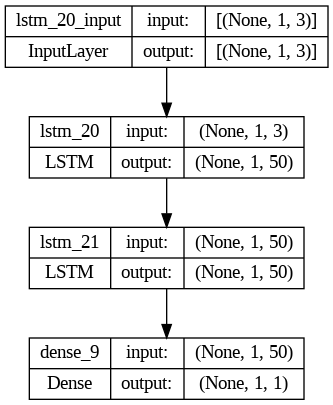

In [62]:
# Building the LSTM Model
lstm = Sequential()

lstm.add(LSTM(50, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True))

lstm.add(LSTM(units=50,return_sequences=True))



lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [63]:
# Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False)

Epoch 1/100
6/6 [==============================] - 7s 217ms/step - loss: 48246.4805
Epoch 2/100
6/6 [==============================] - 0s 7ms/step - loss: 48235.9805
Epoch 3/100
6/6 [==============================] - 0s 63ms/step - loss: 48224.4414
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 48211.2383
Epoch 5/100
6/6 [==============================] - 0s 7ms/step - loss: 48195.6680
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 48176.8984
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 48153.8438
Epoch 8/100
6/6 [==============================] - 0s 8ms/step - loss: 48125.1328
Epoch 9/100
6/6 [==============================] - 0s 7ms/step - loss: 48089.1602
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 48044.0312
Epoch 11/100
6/6 [==============================] - 0s 7ms/step - loss: 47987.3633
Epoch 12/100
6/6 [==============================] - 0s 8ms/step - loss: 47916.2891
Epoch 13/1

### Prediction and Evaluation

In [64]:
# LSTM Prediction
y_pred= lstm.predict(X_test)

1/1 [==============================] - 1s 1s/step


ValueError: ignored

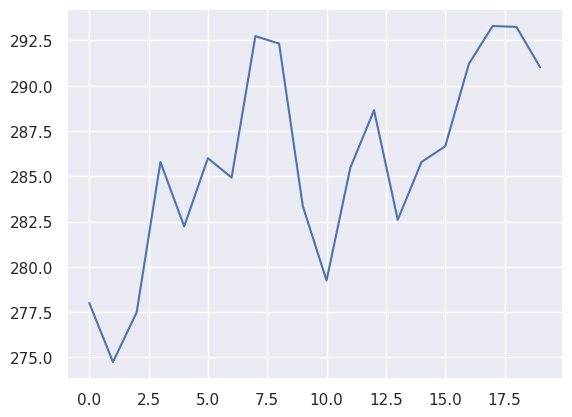

In [65]:
# Predicted vs True Price Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('RSME: ', rmse)
print('MAPE: ', mape)